In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt
import sklearn as sk
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

c:\Users\Chuxu\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
%run ./ESE527_project_setup.ipynb

In [ ]:
import warnings
import optuna
import lightgbm as lgbm
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 
from sklearn.decomposition import LatentDirichletAllocation #package for LDA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,cross_val_score
%matplotlib inline
#define text normalization function
%run ./Text_Normalization_Function.ipynb #defining text normalization function

In [4]:
review_data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore_user_reviews.csv")
APP_data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore.csv")

In [5]:
review_data.head(5)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [6]:
review_null = pd.DataFrame({'Null Values':review_data.isna().sum().sort_values(ascending=False),
'Percentage Null Values':(review_data.isna().sum().sort_values(ascending=False))/(review_data.shape[0])*(100)})
review_data=review_data.dropna()
review_data

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.250000,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.400000,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.000000,0.300000
5,10 Best Foods for You,Best way,Positive,1.000000,0.300000
...,...,...,...,...,...
64222,Housing-Real Estate & Property,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667
64223,Housing-Real Estate & Property,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222
64226,Housing-Real Estate & Property,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000
64227,Housing-Real Estate & Property,I property business got link SMS happy perform...,Positive,0.800000,1.000000


In [7]:
def categorize_Sentiment(sentiment):
    if sentiment =='Positive' :
        return 2
    elif sentiment == 'Neutral':
        return 1
    elif sentiment == 'Negative':
        return 0
    else:
        return np.nan  # Return NaN for ratings that don't match any condition
# Apply the function to the 'Rating' column to create the 'Rating Interval' column

In [8]:
review_data['Rating Interval'] = review_data['Sentiment'].apply(categorize_Sentiment)
review_data_sample=review_data

In [9]:
review_data_sample=review_data.iloc[0:1000,]

### Tokenization

In [10]:
#review_data_sample=review_data_sample[review_data_sample['App']=='10 Best Foods for You']
review_data_sample.head(5)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Rating Interval
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,2
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,2
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,2
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,2
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,2


In [11]:
review_data_sample['Review']=normalize_corpus(review_data_sample['Translated_Review']) 
review_data_sample.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Rating Interval,Review
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,2,like eat delicious food cook food case best fo...
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,2,help eat healthy exercise regular basis
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,2,work great especially grocery store
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,2,best idea us
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,2,best way


In [12]:
Review = review_data_sample["Review"]
Rating = review_data_sample["Rating Interval"]
normalized_train_reviews, normalized_test_reviews, train_polarity, test_polarity = train_test_split(Review, Rating, test_size = 0.2, random_state = 628)

#### Tfidf-Vectorizer Method

In [13]:
vectorizer = CountVectorizer()
Tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1))

In [14]:
feature_matrix_TRAIN = Tfidf_vectorizer.fit_transform(normalized_train_reviews).astype(float)
feature_matrix_TEST = Tfidf_vectorizer.transform(normalized_test_reviews)

#### CountVectorizer + Tfidf-Transformer

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer(max_features=10)
tf_idf_transformer = TfidfTransformer()
feature_matrix_TRAIN = tf_idf_transformer.fit_transform(vectorizer.fit_transform(normalized_train_reviews)).toarray()
feature_matrix_TEST = tf_idf_transformer.transform(vectorizer.transform(normalized_test_reviews)).toarray() 
feature_matrix_TEST = feature_matrix_TEST

In [ ]:
import optuna
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV,cross_val_score
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(feature_matrix_TRAIN,  train_polarity)
    k_folds = 3
    cv_scores = cross_val_score(model, feature_matrix_TRAIN,  train_polarity, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

In [17]:
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(feature_matrix_TRAIN, train_polarity)
y_pred_lgbm=clf_lgbm.predict(feature_matrix_TEST)
accuracy=accuracy_score(test_polarity,y_pred_lgbm)
accuracy

c:\Users\Chuxu\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Chuxu\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Chuxu\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Chuxu\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

[LightGBM] [Warning] feature_fraction is set=0.5875627403686833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5875627403686833
[LightGBM] [Warning] bagging_fraction is set=0.6981474318531918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981474318531918
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5875627403686833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5875627403686833
[LightGBM] [Warning] bagging_fraction is set=0.6981474318531918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981474318531918
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

c:\Users\Chuxu\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Chuxu\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.75

c:\Users\Chuxu\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


<Figure size 500x400 with 0 Axes>

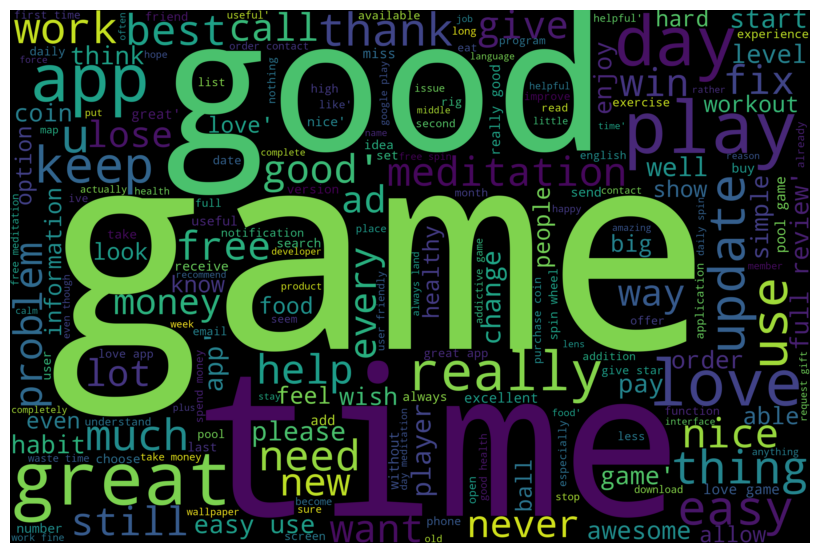

In [23]:
review_data_sample_new = review_data_sample['Review'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(review_data_sample_new))

fig = plt.figure(
    figsize = (5, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

### Sentiment

In [193]:
def analyze_sentiment(text):
    classifier = pipeline('sentiment-analysis')
    result = classifier(text)
    return result[0]['label']

In [158]:
#review_data_sample['Sentiment_tran'] = review_data_sample['Review'].apply(analyze_sentiment)

In [160]:
#def compute_polarity(text):
#    return TextBlob(text).sentiment.polarity
#def compute_subjectivity(text):
#    return TextBlob(text).sentiment.subjectivity
#review_data_sample['Review_polarity'] = review_data_sample['Review'].apply(compute_polarity)
#review_data_sample['Review_subjectivity'] = review_data_sample['Review'].apply(compute_subjectivity)
#review_data_sample

## Bert

In [194]:
import random
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm

In [195]:
review_data_sample=review_data_sample[['Review','Rating Interval']]
review_data_sample

,Review,Rating Interval
0,like eat delicious food cook food case best fo...,2
1,help eat healthy exercise regular basis,2
3,work great especially grocery store,2
4,best idea us,2
5,best way,2
...,...,...
98,nothing special could anything useful,2
99,ok love ok,2
100,like eat delicious food cook food case best fo...,2
101,help eat healthy exercise regular basis,2


In [196]:
review_data_sample['Review']

0      like eat delicious food cook food case best fo...
1                help eat healthy exercise regular basis
3                    work great especially grocery store
4                                           best idea us
5                                               best way
                             ...                        
98                 nothing special could anything useful
99                                            ok love ok
100    like eat delicious food cook food case best fo...
101              help eat healthy exercise regular basis
103                  work great especially grocery store
Name: Review, Length: 100, dtype: object

In [197]:
split_line = int(len(review_data_sample) * 0.6)
train_comments, train_labels = list(review_data_sample[: split_line]['Review']), list(review_data_sample[: split_line]['Rating Interval'])
test_comments, test_labels = list(review_data_sample[split_line:]['Review']), list(review_data_sample[split_line:]['Rating Interval'])
len(train_comments),len(train_labels), len(test_comments), len(test_labels) 

(60, 60, 40, 40)

In [ ]:
# conda install torchvision -c pytorch
# pip install d2l==1.0.0b0

In [198]:
class BERTClassifier(nn.Module):
    def __init__(self, output_dim, pretrained_name="bert-base-uncased"):

        super(BERTClassifier, self).__init__()
        # 定义 Bert 模型
        self.bert = BertModel.from_pretrained(pretrained_name)
        # 外接全连接层
        self.mlp = nn.Linear(768, output_dim)
    def forward(self, tokens_X):
        # 得到最后一层的 '<cls>' 信息， 其标志全部上下文信息
        res = self.bert(**tokens_X)
        # res[1]代表序列的上下文信息'<cls>'，外接全连接层，进行情感分析 
        return self.mlp(res[1])
    """
评估函数，用以评估数据集在神经网络下的精确度
"""
def evaluate(net, review_data_sample, labels_data):
    sum_correct, i = 0, 0
    while i <= len(review_data_sample):
        
        comments = review_data_sample[i: min(i + 8, len(review_data_sample))]
        
        tokens_X = tokenizer(comments, padding=True, truncation=True, return_tensors='pt').to(device=device)

        res = net(tokens_X)                                          # 获得到预测结果

        y = torch.tensor(labels_data[i: min(i + 8, len(review_data_sample))]).reshape(-1).to(device=device)

        sum_correct += (res.argmax(axis=1) == y).sum()              # 累加预测正确的结果
        i += 8

    return sum_correct/len(review_data_sample)                           # 返回(总正确结果/所有样本)，精确率

"""
训练bert_classifier分类器
"""
def train_bert_classifier(net, tokenizer, loss, optimizer, train_comments, train_labels, test_comments, test_labels,
                          device, epochs):
    max_acc = 0.5  # 初始化模型最大精度为0.5
    # 先测试未训练前的模型精确度
    train_acc = evaluate(net, train_comments, train_labels)
    test_acc = evaluate(net, test_comments, test_labels)
    # 输出精度
    print('--epoch', 0, '\t--train_acc:', train_acc, '\t--test_acc', test_acc)


    # 累计训练18万条数据 epochs 次，优化模型
    for epoch in tqdm(range(epochs)):

        i, sum_loss = 0, 0  # 每次开始训练时， i 为 0 表示从第一条数据开始训练


        # 开始训练模型
        while i < len(train_comments):
            comments = train_comments[i: min(i + 8, len(train_comments))]  # 批量训练，每次训练8条样本数据

            # 通过 tokenizer 数据化输入的评论语句信息，准备输入bert分类器
            tokens_X = tokenizer(comments, padding=True, truncation=True, return_tensors='pt').to(device=device)

            # 将数据输入到bert分类器模型中，获得结果
            res = net(tokens_X)

            # 批量获取实际结果信息
            y = torch.tensor(train_labels[i: min(i + 8, len(train_comments))]).reshape(-1).to(device=device)

            optimizer.zero_grad()  # 清空梯度
            l = loss(res, y)  # 计算损失
            l.backward()  # 后向传播
            optimizer.step()  # 更新梯度

            sum_loss += l.detach()  # 累加损失
            i += 8  # 样本下标累加

        # 计算训练集与测试集的精度
        train_acc = evaluate(net, train_comments, train_labels)
        test_acc = evaluate(net, test_comments, test_labels)

        # 输出精度
        print('\n--epoch', epoch+1, '\t--loss:', sum_loss / (len(train_comments) / 8), '\t--train_acc:', train_acc,
              '\t--test_acc', test_acc)

        # 如果测试集精度 大于 之前保存的最大精度，保存模型参数，并重设最大值
        if test_acc > max_acc:
            # 更新历史最大精确度
            max_acc = test_acc

            # 保存模型
            #torch.save(net.state_dict(), 'bert.parameters')

In [199]:
device = d2l.try_gpu()                                  # 获取GPU
net = BERTClassifier(output_dim=3)                      # BERTClassifier分类器，因为最终结果为3分类，所以输出维度为3，代表概率分布
net = net.to(device)                                    # 将模型存放到GPU中，加速计算

# 定义tokenizer对象，用于将评论语句转化为BertModel的输入信息
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loss = nn.CrossEntropyLoss()                                # 损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)      # 小批量随机梯度下降算法

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [200]:
train_bert_classifier(net, tokenizer, loss, optimizer, train_comments, train_labels, test_comments, test_labels, device, 1)

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided []

In [63]:
net = BERTClassifier(output_dim=3)
net = net.to(device)
 
# 加载训练好的模型参数
net.load_state_dict(torch.load('./bert.parameters'))
start = 0
while start < 20:
 
    comment = test_comments[start]
    token_X = tokenizer(comment, padding=True, truncation=True, return_tensors='pt').to(device)
    label = test_labels[start]                          # 实际结果
    result = net(token_X).argmax(axis=1).item()         # 得到预测结果
	
	# 打印评论语句
    print(comment)
    
    # 输出预测结果
    if result == 0:
        print('Predict result: ', 0, '----> Negative', end='\t')
    elif result == 1:
        print('Predict result: ', 1, '----》Neutral', end='\t')
    else:
        print('Predict result: ', 2, '----》Positive', end='\t')
 
	# 输出实际结果
    if label == 0:
        print('Actual Result: ', 0, '----》Negative', end='\t')
    elif label == 1:
        print('Actual Result: ', 1, '----》Neutral', end='\t')
    else:
        print('Actual Result: ', 2, '----》Positive', end='\t')
 
    if result == label:
        print('Correct')
    else:
        print('Wrong')
 
    start += 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


God health
预测结果:  2 ----》好评	实际结果:  1 ----》中评	预测错误
HEALTH SHOULD ALWAYS BE TOP PRIORITY. !!. ON MYSG5.
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
An excellent A useful
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
I found lot wealth form health...
预测结果:  2 ----》好评	实际结果:  1 ----》中评	预测错误
Because I found important.
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
Healthy Eating
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
Very good Simply good
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
On test....
预测结果:  2 ----》好评	实际结果:  1 ----》中评	预测错误
Good.!!
预测结果:  1 ----》中评	实际结果:  2 ----》好评	预测错误
Thanks advice. Downloaded Adobe reader still can't get recipe book?..
预测结果:  1 ----》中评	实际结果:  2 ----》好评	预测错误
No recipe book Unable recipe book.
预测结果:  2 ----》好评	实际结果:  0 ----》差评	预测错误
Absolutely Fabulous Phenomenal
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
Great Love food
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
Excellent It really works
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
Best
预测结果:  2 ----》好评	实际结果:  2 ----》好评	预测正确
WEALTH OF INFORMATION Very in